In [2]:
import pandas as pd
import ast

import geopandas as gpd
import contextily as cx
from shapely.geometry.polygon import Polygon

import matplotlib.pyplot as plt 

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [4]:
# Reading the data
gdf_noise = gpd.read_file('../../data/raw/stoej.json')
gdf_roads = gpd.read_file('../../data/raw/edges.json')


# Casting to new epsg in order to use meters in the buffer zone
gdf_noise = gdf_noise.to_crs(epsg=2583b2)
gdf_roads = gdf_roads.to_crs(epsg=25832)

In [5]:
# Buffer the roads to create an area 
gdf_roads['geometry'] = gdf_roads.geometry.buffer(10)

# Create a spatial index for the noise polygons
noise_sindex = gdf_noise.sindex

# Intersect buffered roads with noise polygons using the spatial index and store intersection results
intersection_results = []
for road in tqdm(gdf_roads.itertuples(), total=len(gdf_roads), desc='Processing roads'):
    possible_matches_i = list(noise_sindex.intersection(road.geometry.bounds))
    possible_matches = gdf_noise.iloc[possible_matches_i]

    road_area = road.geometry.area
    for noise_polygon in possible_matches.itertuples():
        if road.geometry.intersects(noise_polygon.geometry):
            intersection = road.geometry.intersection(noise_polygon.geometry)
            
            if not intersection.is_empty:
                intersection_area = intersection.area

                intersection_results.append({
                    'road_id': road.id,
                    'road_length': road.geometry.length,
                    'noise_id': noise_polygon.id,
                    'intersection_area': intersection_area,
                    'road_area': road_area,
                    'noise_level': noise_polygon.isov1
                })

# Convert the intersection results to a DataFrame
intersections_df = pd.DataFrame(intersection_results)

# Calculate the total intersection area for each road by summing up 
# the intersection areas of all noise polygons that intersect with the road.
intersection_sums = intersections_df.groupby('road_id')['intersection_area'].sum().reset_index()
intersection_sums.rename(columns={'intersection_area': 'total_intersection_area'}, inplace=True)

# Merge to get the total intersection area per road
intersections_df = intersections_df.merge(intersection_sums, on='road_id')

# Calculate normalized intersection percentage
intersections_df['intersection_percentage'] = intersections_df['intersection_area'] / intersections_df['total_intersection_area']

#Calculate weighted noise based on normalized intersection percentage
intersections_df['weighted_noise'] = intersections_df['noise_level'] * intersections_df['intersection_percentage']

# Group by road id to sum the weighted noise levels
road_noise = intersections_df.groupby('road_id')['weighted_noise'].sum().reset_index()

# Merge the noise information back to the original road dataset
gdf_roads['id'] = gdf_roads['id'].astype(str)  # Ensuring 'id' is of the same data type
road_noise['road_id'] = road_noise['road_id'].astype(str)  # Ensuring 'road_id' is of the same data type
gdf_roads = gdf_roads.merge(road_noise, left_on='id', right_on='road_id', how='left').drop(columns=['road_id'])

#Ensure the new 'weighted_noise' does not have NaNs (Frederiksberg data)
gdf_roads['weighted_noise'] = gdf_roads['weighted_noise'].fillna(0)



Processing roads: 100%|█████████████████████████████████████████████████████████| 61939/61939 [1:11:20<00:00, 14.47it/s]


In [6]:
len(gdf_roads)

61939

In [7]:
gdf_roads.to_file('../data/noise_cph_frb.json')

In [37]:
#Since Frederiksberg is in gdf_roads, but not gdf_noise, we have ~16.000 rows with no noise values; the roads in Frederiksberg.
#We will filter away any roads with noise <= 0.0

gdf_roads_cph = gdf_roads[gdf_roads.weighted_noise > 0.0]


In [8]:
len(gdf_roads[gdf_roads.weighted_noise > 0.0])

45869

In [39]:
gdf_roads_cph.weighted_noise.describe().round(decimals=2)

count    45869.00
mean        60.48
std          5.86
min         53.00
25%         54.77
50%         59.78
75%         66.57
max         70.29
Name: weighted_noise, dtype: float64

In [15]:
gdf_roads_cph.to_file('../data/noise_cph_kommune.json')

In [ ]:
# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
gdf_roads_cph.plot(
    column='weighted_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=gdf_roads_cph.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.savefig('../pictures/street_noise_map_02.png')


In [7]:
gdf_roads = gpd.read_file('../../data/raw/noise_cph_frb.json')

**Below are all the roads that did not get assigned any noise levels from the polygons. The big blue cluster is Frederiksberg, which was not part of the noise data. The rest is *probably* small edges that did not get a bigger enough buffer zone to match with any polygons.**

In [56]:
missing_roads = gdf_roads[gdf_roads.weighted_noise > 0.0]

In [ ]:
#DELETE!!1

#frb = gdf_roads[gdf_roads.weighted_noise > 0.0]
# frb.weighted_noise.hist()
# # len(frb)

# gdf_noise = gpd.read_file('../../data/raw/stoej.json')
# gdf_noise.isov1.hist()
# list(gdf_noise)

gdf_samlet = gpd.read_file('../../data/noise_edges.csv')

,id,access,betweenness,junction,length,oneway,weighted_noise,geometry
0,"(118725, 298795432, 0)",None,3.989112e-07,None,112.872,True,64.385753,"POLYGON ((724040.827 6175542.070, 724080.641 6..."
1,"(118725, 6357644306, 0)",None,4.920812e-05,None,40.497,True,68.661369,"POLYGON ((724046.688 6175575.314, 724054.375 6..."
2,"(118732, 6534097568, 0)",None,7.166803e-06,None,3.887,True,68.796874,"POLYGON ((724009.600 6174339.933, 724010.215 6..."
3,"(118732, 283603631, 0)",None,1.045631e-05,None,7.668,True,68.872383,"POLYGON ((723998.751 6174348.789, 723999.520 6..."
4,"(118735, 8977396171, 0)",None,6.068286e-06,None,9.397,True,69.000000,"POLYGON ((724639.025 6174941.422, 724639.660 6..."
...,...,...,...,...,...,...,...,...
61915,"(11753370240, 11753370233, 0)",None,3.776058e-06,None,59.697,True,68.294369,"POLYGON ((724868.077 6177131.320, 724876.877 6..."
61916,"(11753370245, 11753370231, 0)",None,2.629188e-07,None,7.363,False,68.972336,"POLYGON ((724871.051 6177047.891, 724866.834 6..."
61917,"(11753370245, 2428138770, 0)",None,2.516163e-05,None,64.369,True,68.889800,"POLYGON ((724890.039 6177075.910, 724899.308 6..."
61918,"(11753370256, 3491860673, 0)",None,0.000000e+00,None,7.153,False,69.000000,"POLYGON ((721498.907 6178019.799, 721498.062 6..."


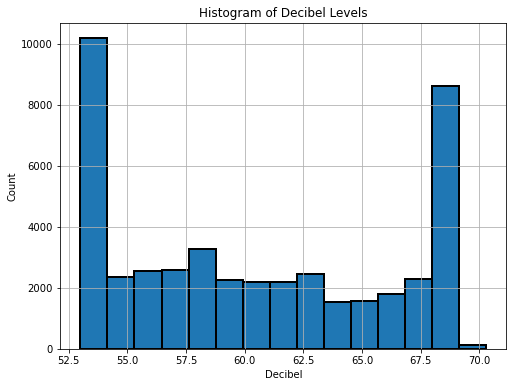

In [55]:
# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(frb['weighted_noise'], bins=15, edgecolor='black', linewidth=2)
plt.xlabel('Decibel')
plt.ylabel('Count')
plt.title('Histogram of Decibel Levels')
plt.grid(True)


plt.savefig('../../pictures/linestrings_decibel.png', bbox_inches='tight')


In [28]:
gdf_noise.kategori.value_counts()

Lden      3463
Lnight     150
Name: kategori, dtype: int64

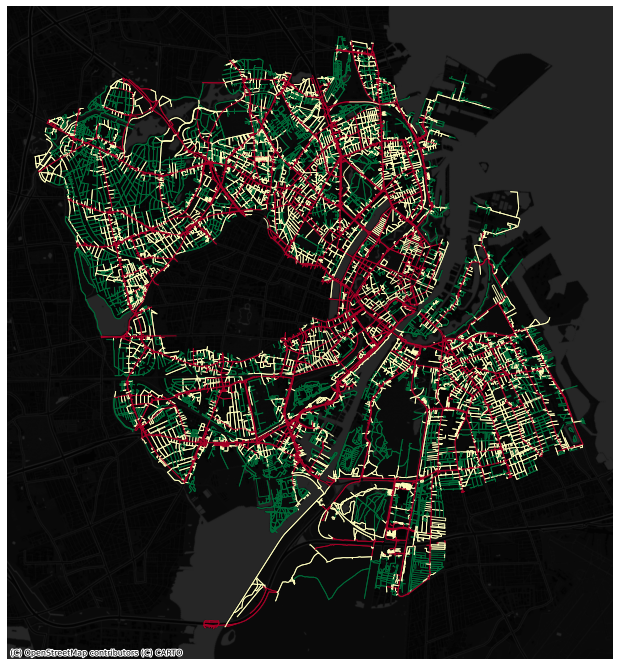

In [59]:
# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
missing_roads.plot(
    column='weighted_noise',
    scheme='quantiles',
    k=3,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=missing_roads.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.savefig('../../pictures/street_noise_map_no_frb.png',bbox_inches='tight')
